# Input

In [1]:
system_path = "/Users/jeeyenpersonal/Documents/kaya-services/services"
proposal_id = '9YJQWolIoQ2coRMfYc5U'
google_cred_path = "/Users/jeeyenpersonal/Documents/kaya-services/services/ad_research/../../.local/kaya-apps-00-prod.json"

# Library

In [2]:
import os
import sys

In [3]:
print(system_path)
sys.path.append(system_path) # go to parent dir

/Users/jeeyenpersonal/Documents/kaya-services/services


In [4]:
os.environ['GCP_PROJECT_NAME'] = 'kaya-apps-00'
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = google_cred_path
os.environ['ENV'] = 'LOCAL_PROD'

In [5]:
from secret_manager.set_env_variables_from_secrets import set_env_variables_from_secrets

In [6]:
set_env_variables_from_secrets(secret_ids=["ALGOLIA_API_KEY", "SEMRUSH_API_KEY", "OPENAI_API_KEY"])

Set environment variable for ALGOLIA_API_KEY
Set environment variable for SEMRUSH_API_KEY
Set environment variable for OPENAI_API_KEY


In [7]:
import pandas as pd
from firestore import FirestoreClient
from algoliasearch.search_client import SearchClient
from dateutil.relativedelta import relativedelta

In [8]:
import uuid

import seaborn as sns
import matplotlib.pyplot as plt
from storage.upload_blob import upload_blob

In [9]:
_FS = FirestoreClient()

Initialising Firestore App:  {'kaya-apps-00'}


# Functions

In [10]:
def save_and_upload_fig(fig, filename_with_ext, proposal_id):
    fig.write_image(filename_with_ext)

    storage_url = upload_blob(
        _IMAGE_BUCKET, 
        source_file_name=filename_with_ext, 
        destination_blob_name=f"proposal/{proposal_id}/overview/{filename_with_ext}", 
        is_public=True
    )
    return storage_url

In [11]:
def months_between_dates(start_date, end_date):
    """
    Generate a DataFrame with a row for each month between two dates.
    
    Parameters:
    - start_date (str): The start date in "YYYY-MM-DD" format.
    - end_date (str): The end date in "YYYY-MM-DD" format.
    
    Returns:
    - pd.DataFrame: A DataFrame with a single column, 'Month', listing months between the start and end date.
    """
    start = pd.to_datetime(start_date)
    end = pd.to_datetime(end_date)
    
    # Generate the month range
    total_months = lambda dt: dt.month + 12 * dt.year
    months = [start + relativedelta(months=+i) for i in range(total_months(end) - total_months(start) + 1)]
    
    # Format the months and create the DataFrame
    months_str = [dt.strftime('%Y-%m') for dt in months]
    df = pd.DataFrame(months_str, columns=['month'])
    
    return df

In [12]:
def count_active_ads_per_month(df, **kwargs):
    # Create a monthly date range from the minimum start_date to maximum end_date
    start_min = df['first_seen_dt'].min()
    end_max = df['last_seen_dt'].max()

    # Create a date object for the first day of start_date and end_date month
    start_min_month = start_min.replace(day=1)
    end_max_month = end_max.replace(day=1)

    months = pd.date_range(start=start_min_month, end=end_max_month, freq='MS')

    # Initialize a dictionary to hold the count of active ads for each month
    active_ads_count = {month.strftime('%Y-%m'): 0 for month in months}

    # Check each ad against each month
    active_ads_count = []
    for month in months:
        month_end = month + pd.offsets.MonthEnd()
        active_ads_df = df[(df['first_seen_dt'] <= month_end) & (df['last_seen_dt'] >= month)]
        
        # if in a given month, we saw ads that have definite first and last seen (ie probability = 1), assign probability = 1
        active_ads_probability = active_ads_df['probability'].max()
        
        active_ads_count.append(
            {'month': month.strftime('%Y-%m'), 'count': active_ads_df.shape[0], 'probability': active_ads_probability, **kwargs}
        )

    return active_ads_count

# Execute

In [13]:
p = _FS.get_single_document("proposal", proposal_id)
# proposal_company_ids = [p["proposal_company_id"]] + list(p["competitors"].values())

In [14]:
p

{'created_at': '2024-05-14T10:55:15Z',
 'marketing_ideas': "**Awareness**\n\nPain point:\nUsers are concerned about the environmental impact of single-use plastics.\n\nExample ad copies:\n- Join HydrosLife's Mission to Save the Planet – Ditch Single-Use Plastics Today!\n- Every Sip Counts – Switch to HydrosLife and Make a Difference!\n- HydrosLife – Your Eco-Friendly Solution to a Healthier Planet!\n\nDesire:\nUsers want to ensure they're drinking clean, filtered water quickly and efficiently.\n\nExample ad copies:\n- Experience Unmatched Purity with HydrosLife's Fast-Filter Tech!\n- Speed & Purity in Every Pour – Discover HydrosLife Today!\n- Clear, Clean, Quick – HydrosLife's Filters Are Changing the Game!\n\n\n\n**Consideration**\n\nPain point:\nUsers are looking for high-quality, reliable water filtration systems that match their lifestyle.\n\nExample ad copies:\n- Pure Water, Pure Life – Trust in HydrosLife's Superior Filtration!\n- Taste the Quality, Feel the Difference with Hydr

In [15]:
comp_company_id_map = {
    v: k for k, v in p['competitors'].items()
}

In [16]:
proposal_company_id_mapping = {**comp_company_id_map, p['proposal_company_id']: p['domain']}
proposal_company_id_mapping

{'c6Yl5sqDNnW332qJSwXQ': 'drinkcirkul.com/',
 'd13SWUzDlOQaeFVnUNsC': 'brita.com',
 '19nGuLBeKDT2Np1d9QKk': 'drinksoma.com',
 'iCQESooXqodU9IjJiUnL': 'hydroslife.com'}

In [60]:
lead_domain = p['domain']

## Get data

In [17]:
alg_client = SearchClient.create("9UOFA9X1DB", os.environ['ALGOLIA_API_KEY'])
ad_research_sample_index = alg_client.init_index("ad_research_sample")

all_ads_out = ad_research_sample_index.browse_objects(
    {"filters": f"proposal_id:{proposal_id}"}
)

In [18]:
all_ads_algolia = [a for a in all_ads_out]

if len(all_ads_algolia) == 0:
    raise Exception("No ads found in Algolia")


In [19]:
all_ads_df = pd.DataFrame(all_ads_algolia)

print(all_ads_df.shape)

if all_ads_df.shape[0] == 0:
    raise (f"Terminating. No ads found for {proposal_id}..")

(320, 37)


In [20]:
all_ads_df.head().T

0  \
platform                                                        meta_ads   
format                                                             video   
landing_page_url                  https://drinkcirkul.com/pages/brittney   
landing_page_full_url             https://drinkcirkul.com/pages/brittney   
metrics                                                               []   
ctas                                                        [Learn more]   
ad_id                                                      6597521047253   
headline                                                            None   
body                   After school chaos is a real thing. The girls ...   
tags                                                                  []   
first_seen                                                    2024-05-08   
last_seen                                                     2024-05-14   
num_variants                                                         1.0   
channels                                [facebook, instagram, messenger]   
link_description                                         drinkcirkul.com   
audience_targeting                                                    []   
uuid                                16c46f1d-d21d-4d8f-844a-acd0889a42ea   
proposal_company_id                                 c6Yl5sqDNnW332qJSwXQ   
proposal_id                                         9YJQWolIoQ2coRMfYc5U   
video_url              https://video-mia3-1.xx.fbcdn.net/v/t42.1790-2...   
original_image_url     https://scontent-mia3-2.xx.fbcdn.net/v/t39.354...   
business_name                                                Drinkcirkul   
domain                                                  drinkcirkul.com/   
industry                                                                   
sub_industry                                                               
description            DrinkCirkul is a transformative beverage compa...   
is_featured                                                        False   
objectID                                          meta_ads_6597521047253   
is_dco                                                               NaN   
caption                                                              NaN   
cta_text                                                             NaN   
slides                                                               NaN   
num_tags                                                             NaN   
advertiser_social_id                                                 NaN   
advertiser_name                                                      NaN   
image_url                                                            NaN   
days_active                                                          NaN   

                                                                       1  \
platform                                                        meta_ads   
format                                                             video   
landing_page_url                   https://drinkcirkul.com/pages/rebecca   
landing_page_full_url              https://drinkcirkul.com/pages/rebecca   
metrics                                                               []   
ctas                                                        [Learn more]   
ad_id                                                      6597520476653   
headline                                                            None   
body                   🩷 ✈️ 💧 🌴 Traveling with a big family we have t...   
tags                                                                  []   
first_seen                                                    2024-05-08   
last_seen                                                     2024-05-14   
num_variants                                                         1.0   
channels                                [facebook, instagram, messenger]   
link_description                          

In [21]:
from dateutil.relativedelta import relativedelta
import datetime as dt

## Process missing first and last seen

Ads library only provides data from the last 12 months. However the first and last seen dates aren't always available. To handle this scenario, we'll fillna with dates from 12M ago and today, and assign a 50% probability to indicate "maybe".

In [22]:
today = dt.date.today()

In [23]:
a_year_ago = today - relativedelta(years=1)
a_year_ago

datetime.date(2023, 5, 14)

In [24]:
# assign default probability of 1
all_ads_df['probability'] = 1

In [25]:
filter_null_first_seen = all_ads_df['first_seen'].isnull()
all_ads_df.loc[filter_null_first_seen, 'first_seen'] = a_year_ago
all_ads_df.loc[filter_null_first_seen, 'probability'] = 0.5

In [26]:
filter_null_last_seen = all_ads_df['last_seen'].isnull()
all_ads_df.loc[filter_null_last_seen, 'last_seen'] = today
all_ads_df.loc[filter_null_last_seen, 'probability'] = 0.5

In [27]:
for sm in ['first_seen', 'last_seen']:
    all_ads_df[f'{sm}_month'] = all_ads_df[sm].str[:7]
    all_ads_df[f'{sm}_dt'] = pd.to_datetime(all_ads_df[sm])

In [28]:
all_ads_df['domain'] = all_ads_df['proposal_company_id'].map(proposal_company_id_mapping)

In [29]:
all_ads_df['platform_shortname'] = all_ads_df['platform'].map(
    {
        'tiktok_ads': 'TT',
        'meta_ads': 'M',
        'linkedin_ads': 'LI',
        'google_ads': "G", 
        'bing_ads': "B"
    }
)

In [30]:
 all_ads_df['platform'].unique()

array(['meta_ads', 'google_ads', 'bing_ads'], dtype=object)

In [31]:
all_ads_df['company_platform'] = all_ads_df['business_name'] + " • " + all_ads_df['platform_shortname']

In [32]:
summarised_dfs = []

for dm in all_ads_df['company_platform'].unique():
    try:
        summarised_dfs += count_active_ads_per_month(all_ads_df[all_ads_df['company_platform']==dm], company_platform=dm)
    except:
        print("Error: ", dm)
        pass
    
summarised_df = pd.DataFrame(summarised_dfs)

In [33]:
summarised_df.head()

month  count  probability company_platform
0  2024-02      9          1.0  Drinkcirkul • M
1  2024-03     10          1.0  Drinkcirkul • M
2  2024-04     33          1.0  Drinkcirkul • M
3  2024-05     75          1.0  Drinkcirkul • M
4  2024-05     16          1.0        Brita • M

In [34]:
summarised_df.dtypes

month                object
count                 int64
probability         float64
company_platform     object
dtype: object

In [35]:
summarised_df.loc[summarised_df['count'] > 0, 'is_active'] = 1

### Manually add data for heatmap

In [36]:
# # unhash this to manually add data

# # data to be added
# start_date = (a_year_ago + relativedelta(day=1)).strftime('%Y-%m-%d')
# end_date = '2024-04-01'
# month_df = months_between_dates(start_date, end_date)

# data = []
# month_list = month_df['month'].tolist()

# company_platforms = [
#     "Walmart • G", 
#     "Target • G", 
#     "Wayfair • G",
#     "Walmart • M", 
#     "Target • M", 
#     "Wayfair • M",

# ]

# for month in month_list:
#     for c in company_platforms:
#         data.append([month, 1, 1.0, c])

# month_list = month_df[1:]['month'].tolist()

# added_df = pd.DataFrame(data, columns=['month', 'count', 'probability', 'company_platform'])


# # concat with original table
# summarised_df = pd.concat([summarised_df, added_df])

# summarised_df.head()

## Plot Heatmap

In [37]:
start_date = (a_year_ago + relativedelta(day=1)).strftime('%Y-%m-%d')
end_date = today.strftime('%Y-%m-%d')
month_df = months_between_dates(start_date, end_date)

pivot_df = pd.pivot_table(
    summarised_df,
    index='month',
    columns='company_platform',
    aggfunc='max', 
    values='probability'
).reset_index()

plot_df = pd.merge(
    month_df,
    pivot_df,
    how='left',
    on='month'
).set_index('month').fillna(0)

plot_df.index = plot_df.index.str[:7]
plot_df = plot_df.T

# update col names so the plot is not so crowded
ori_cols = plot_df.columns
plot_df.columns = [c if idx%3 == 0 else '' for idx, c in enumerate(ori_cols)]


# do the same for index / row
ori_index = plot_df.index
new_index = []
last_biz = ''
for idx, biz_platform in enumerate(ori_index):
    cur_biz = biz_platform.split(" • ")[0]
    cur_platform = biz_platform.split(" • ")[1]
    
    if cur_biz == last_biz:
        new_index.append(cur_platform)
    else:
        new_index.append(f"➤ {cur_biz}  •  {cur_platform}")
    
    last_biz = cur_biz

plot_df.index = new_index

In [38]:
plot_df

2023-05            2023-08            2023-11            \
➤ Brita  •  B            0.0  0.5  0.5      0.5  0.5  0.5      0.5  0.5  0.5   
G                        1.0  1.0  1.0      1.0  1.0  1.0      1.0  1.0  1.0   
M                        0.0  0.0  0.0      0.0  0.0  0.0      0.0  0.0  0.0   
➤ Drinkcirkul  •  G      1.0  1.0  1.0      1.0  1.0  1.0      1.0  1.0  1.0   
M                        0.0  0.0  0.0      0.0  0.0  0.0      0.0  0.0  0.0   
➤ Drinksoma  •  G        1.0  1.0  1.0      1.0  1.0  1.0      1.0  1.0  1.0   
➤ Hydroslife  •  G       0.0  1.0  1.0      1.0  1.0  1.0      0.0  0.0  0.0   

                     2024-02            
➤ Brita  •  B            0.5  0.5  0.5  
G                        1.0  1.0  1.0  
M                        0.0  0.0  0.0  
➤ Drinkcirkul  •  G      1.0  1.0  1.0  
M                        1.0  1.0  1.0  
➤ Drinksoma  •  G        1.0  1.0  1.0  
➤ Hydroslife  •  G       0.0  0.0  0.0

In [39]:
_IMAGE_BUCKET = "kaya-apps-00-public"

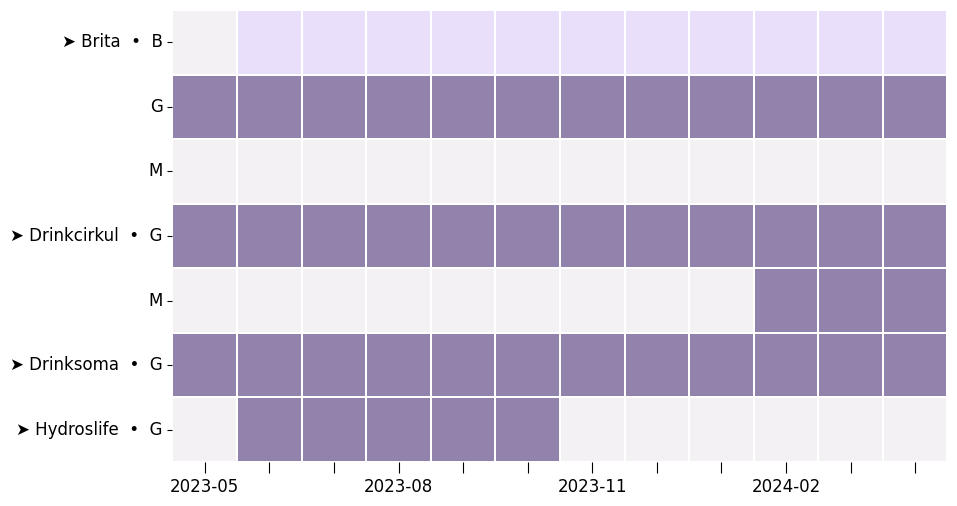

WARNING, FILE WILL BE MADE PUBLIC!
File /tmp/competitor_ad_monthly_breakdown_heatmap_d6ed2823-20c8-4125-97a8-99b93fa64f64.png uploaded to kaya-apps-00-public/proposal/9YJQWolIoQ2coRMfYc5U/overview/competitor_ad_monthly_breakdown_heatmap_d6ed2823-20c8-4125-97a8-99b93fa64f64.png.

Legend
------
Black: Not running any ads
Green: Running ads
Cream: Might be running ads



In [40]:
heatmap_filename = f'competitor_ad_monthly_breakdown_heatmap_{uuid.uuid4()}.png'
heatmap_filepath = f'/tmp/{heatmap_filename}'

plt.rcParams["font.family"] = "sans-serif"
plt.rcParams["font.size"] = 12
plt.figure(figsize = (10, 10))

ax = sns.heatmap(
    plot_df, 
    cmap=['#F4F1F4', '#E9DFFB', '#9283AC'], 
    linewidths=0.005,
    cbar=False,
    square=True
)

ax.tick_params(axis='x', rotation=0, size=8)
# ax.tick_params(axis='y', rotation=0, size=12)
# ax.set_ylabel("", fontsize=60)


plt.show()
fig = ax.get_figure()
fig.savefig(heatmap_filepath, bbox_inches="tight")


heatmap_storage_url = upload_blob(
    _IMAGE_BUCKET, 
    source_file_name=heatmap_filepath, 
    destination_blob_name=f"proposal/{proposal_id}/overview/{heatmap_filename}", 
    is_public=True
)

print(f"""
Legend
------
· Dark: Running ads
· Light: Might be running ads
· Grey: Not running ads
"""
)

# SEM Budget

In [41]:
from google.gutils.bigquery import run_query

In [42]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [43]:
from tabulate import tabulate

In [44]:
import numpy as np

In [45]:
def round_to_n_significant_digits(x, n):
    """Round a number x to n significant digits."""
    if x == 0:
        return 0
    else:
        return round(x, n - int(np.floor(np.log10(abs(x)))) - 1)

def round_dataframe(df, n):
    """Apply n significant digits rounding to all numeric values in the DataFrame."""
    return df.applymap(lambda x: round_to_n_significant_digits(x, n) if isinstance(x, (int, float)) else x)


In [46]:
def create_table_image(dataframe):
    """Create an image of the DataFrame styled as a beautiful table with custom column alignment."""
    fn = f'/tmp/dataframe_table_{uuid.uuid4()}.png'
    
    # Set the style of the matplotlib
    plt.style.use('ggplot')
    
    # Increase the default font size
    plt.rcParams.update({'font.size': 16})
    
    # Create a figure and a single subplot
    fig, ax = plt.subplots(figsize=(10, 2))  # Adjust the size as needed
    
    # Hide the axes
    ax.axis('tight')
    ax.axis('off')
    
    # Create the table and adjust its scaling and coloring
    table = ax.table(cellText=dataframe.values, colLabels=dataframe.columns, loc='center', cellLoc='center')
    
    # Adjust table scale
    table.scale(1, 2)  # Width, height scale of the cells

    # Change header row background color
    for (i, col) in enumerate(dataframe.columns):
        table[(0, i)].set_facecolor('#fafafa')  # Set background color of header cells
        table[(0, i)].set_text_props(weight='bold')  # Make the header text bold

    # Align columns: left-align the first column, right-align others
    for key, cell in table.get_celld().items():
        if key[1] == 0:  # First column
            cell.set_text_props(ha='left')
        else:  # Other columns
            cell.set_text_props(ha='right')

    # Optionally, set a font color, or background color
    table.auto_set_font_size(False)
    table.set_fontsize(14)  # Set font size
    table.auto_set_column_width(col=list(range(len(dataframe.columns))))  # Adjust to fit column width
    
    plt.savefig(fn, bbox_inches='tight', dpi=300)  # Save the figure as a PNG file
    storage_url = upload_blob(
        _IMAGE_BUCKET, 
        source_file_name=fn, 
        destination_blob_name=f"proposal/{proposal_id}/overview/{fn}", 
        is_public=True
    )
    plt.show()  # Display the figure
    return storage_url

In [47]:
domains_to_query = tuple(proposal_company_id_mapping.values())

In [48]:
sql = f"""
select *
from kaya-apps-00.src_coin.spyfu_domain_adwords_organic_traffic_cost_stats
where domain in {domains_to_query}
"""
semrush_df = run_query(sql, "dataframe")

Executing query:
 
select *
from kaya-apps-00.src_coin.spyfu_domain_adwords_organic_traffic_cost_stats
where domain in ('drinkcirkul.com/', 'brita.com', 'drinksoma.com', 'hydroslife.com')



In [50]:
print(semrush_df.shape)

(518, 18)


In [51]:
def save_and_upload_fig(fig, filename_with_ext, proposal_id, proposal_company_id):
    fig.write_image(filename_with_ext)

    filename = filename_with_ext.replace('/tmp/', '')

    storage_url = upload_blob(
        _IMAGE_BUCKET, 
        source_file_name=filename_with_ext, 
        destination_blob_name=f"proposal/{proposal_id}/{proposal_company_id}/{filename}", 
        is_public=True
    )
    return storage_url

In [52]:
sem_str = ""

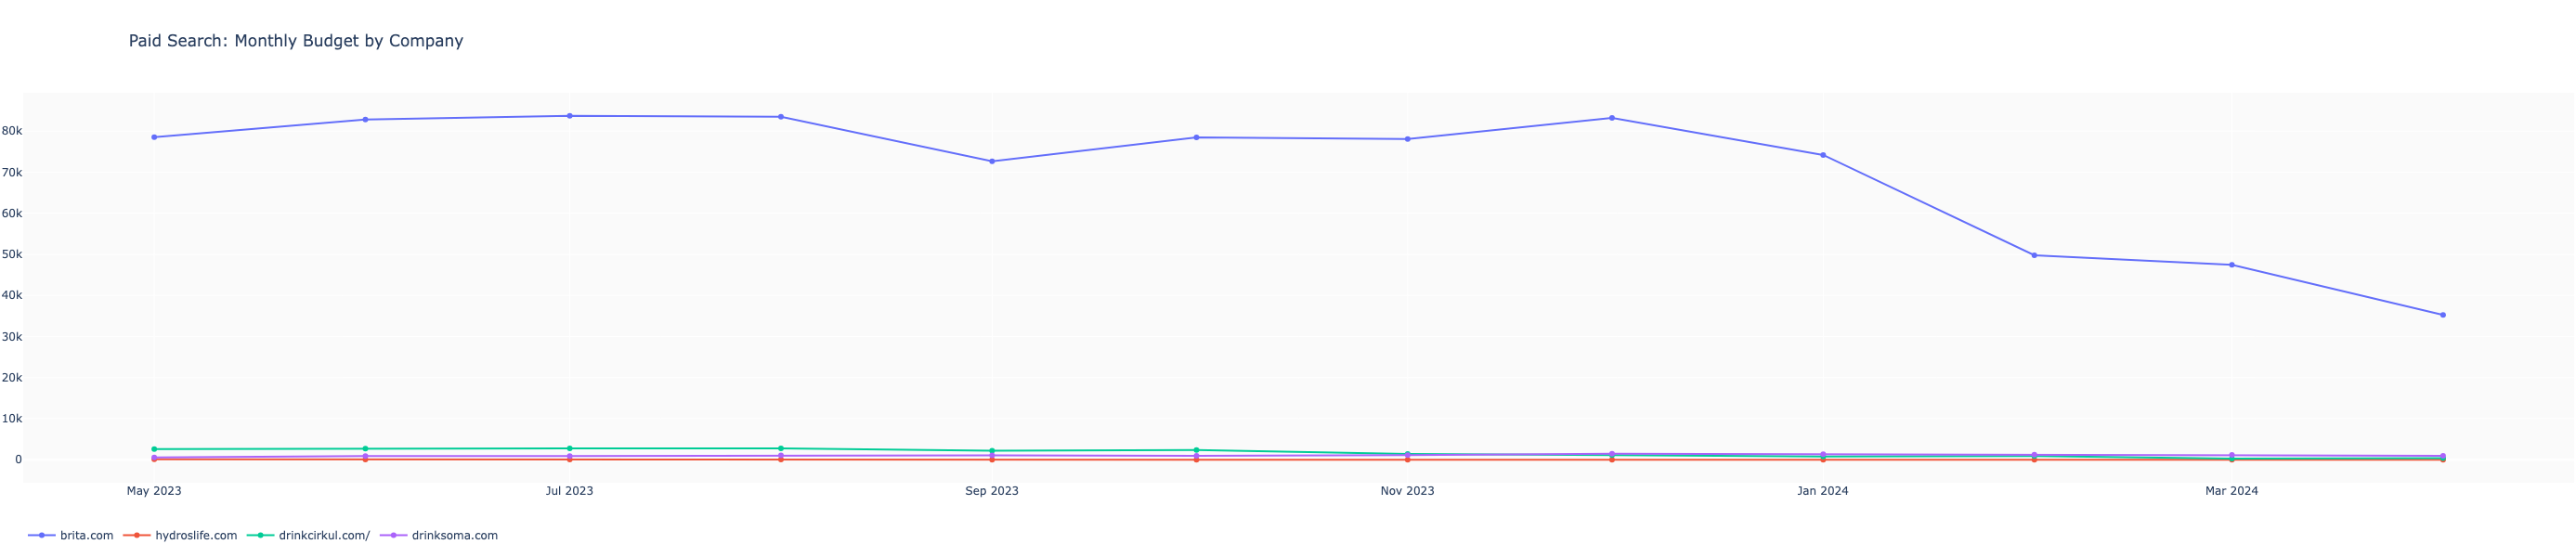

WARNING, FILE WILL BE MADE PUBLIC!
File /tmp/sem_budget_4c75d026-4bee-4fb0-ac8b-29275cc513b3.png uploaded to kaya-apps-00-public/proposal/9YJQWolIoQ2coRMfYc5U/overview/sem_budget_4c75d026-4bee-4fb0-ac8b-29275cc513b3.png.
WARNING, FILE WILL BE MADE PUBLIC!
File /tmp/dataframe_table_fab6788d-ffce-4629-ad18-04ea8ae6f181.png uploaded to kaya-apps-00-public/proposal/9YJQWolIoQ2coRMfYc5U/overview//tmp/dataframe_table_fab6788d-ffce-4629-ad18-04ea8ae6f181.png.


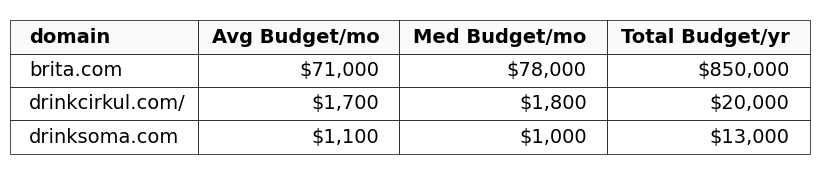

In [61]:
if semrush_df.shape[0] > 0:
    # PLOT CHART
    budget_fn = f'sem_budget_{uuid.uuid4()}.png'
    fig = go.Figure()
    
    filtered_semrush_df = semrush_df[semrush_df['yyyymm'] >= a_year_ago.strftime("%Y-%m")]

    for dm in filtered_semrush_df['domain'].unique():
        dm_plot_df = filtered_semrush_df[filtered_semrush_df['domain'] == dm].sort_values(by=['yyyymm'])
        fig.add_trace(
            go.Scatter(x=dm_plot_df['yyyymm'], y=dm_plot_df['adwords_cost'], name=dm)
        )
    fig.update_layout(
        # barmode='relative', 
        title_text='Paid Search: Monthly Budget by Company',
        height=600, 
        width=1000, 
        legend=dict(orientation="h"),
        paper_bgcolor='rgba(0,0,0,0)',
        plot_bgcolor='#fafafa',
        margin=dict(l=2, r=2),
    )
    fig.show()


    sem_budget_storage_url = save_and_upload_fig(
        fig,
        f"/tmp/{budget_fn}",
        proposal_id,
        'overview'
    )
    
    # PLOT TABLE. EXCLUDE LEAD DOMAIN
    stats_sem_budget_df = pd.pivot_table(
        filtered_semrush_df[filtered_semrush_df['domain'] != lead_domain],
        index='domain',
        aggfunc=['mean', 'sum', 'median'],
        values='adwords_cost'
    ).astype(int)

    stats_sem_budget_df.columns = ['_'.join(col).strip() for col in stats_sem_budget_df.columns.values]

    rename_cols = {
        'domain_': 'Domain', 
        'mean_adwords_cost': 'Avg Budget/mo', 
        'median_adwords_cost': 'Med Budget/mo',
        'sum_adwords_cost': 'Total Budget/yr',
    }
    stats_sem_budget_df.rename(columns=rename_cols, inplace=True)
    
    stats_sem_budget_df = round_dataframe(stats_sem_budget_df, 2)

    for c in stats_sem_budget_df.columns:
        stats_sem_budget_df[c] = stats_sem_budget_df[c].apply(lambda x: f"${x:,.0f}")

    stats_sem_budget_df = stats_sem_budget_df[['Avg Budget/mo', 'Med Budget/mo', 'Total Budget/yr']].reset_index()

    # Plot table 
    table_storage_url = create_table_image(stats_sem_budget_df)

    # get sem keyword gsheet url
    keyword_gsheet_url = ""

    pc = _FS.get_single_document("proposal", proposal_id)
    keyword_gsheet_url = pc.get("keyword_gsheet_url", "")
    
    # compile sem summary
    sem_str = f"""
**Paid Search**
Here is an estimate of your competitors' monthly Google Ads budget. These data are sourced from third-party tools (Spyfu/Semrush), and we find them to be inaccurate most of the time. Hence, pay more attention to the magnitude and relative values between competitors and month-on-month changes, rather than their absolute values.
![Budget comparison]({sem_budget_storage_url} "Budget comparison")

![Budget comparison table]({table_storage_url} "Budget comparison table")
"""
    
    # add keyword gsheet url to summary if available
    if len(keyword_gsheet_url) > 0:
        sem_str += f"""
        
See the list of keywords here: [GSheet]({keyword_gsheet_url})
"""

In [52]:
proposal_summary_md = f"""
From the chart below, you can see an overview of where your competitors have been running ads since {start_date[:]}. Use this information as a guide to gauge whether a channel works for them.
![Budget comparison]({heatmap_storage_url} "Ads Channel")
Legend:
· Dark: Running ads
· Light: Might be running ads\n
· Grey: Not running ads
<br />

{sem_str}
"""

# if len(paid_social_desc) > 0:
#     proposal_summary_md += f"""
# <br />
# **Paid Social**
# {paid_social_desc}
# """
    
    

_FS.update_document(
    "proposal",
    proposal_id,
    {"competitor_ads_analysis_summary": proposal_summary_md}
)

Doc 2rFE0i58OwiG2S7eroAZ updated
